# My personal attempt at solving the Titanic database


The data elaboration has been adapted from and inspired by the contents of [this page](https://mlguy.org/2018/06/11/tutorial-kaggle-titanic-competition-exploratory-data-analysis-and-classification/).

In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder # For one-hot encoding

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

# Any results you write to the current directory are saved as output.

# Load the data
train_dataframe = pd.read_csv("train.csv", sep=",")
Xsubm_dataframe = pd.read_csv("test.csv", sep = ",")

## Exploration, integration and completion of the dataset

1. Analyse the empty cells (NaNs) and try to infer their value
2. Bin the age and converting categorical features into one-hot encoding
3. Find correlations (or lack thereof) between the data

In [8]:
print(train_dataframe.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


### Exploratory analysis
Use 
* sns.countplot to "count" the number of elements, divided according to the "x" label
* sns.catplot (with kind = "count") to count over two subgroups (using the 'col' kwargs).


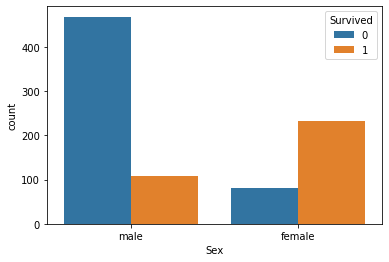

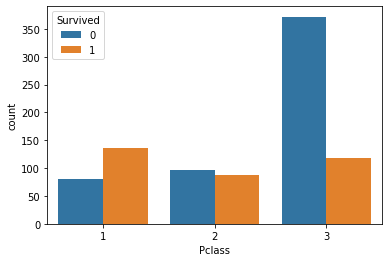

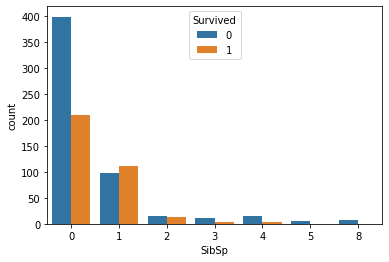

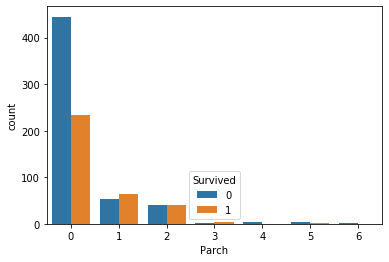

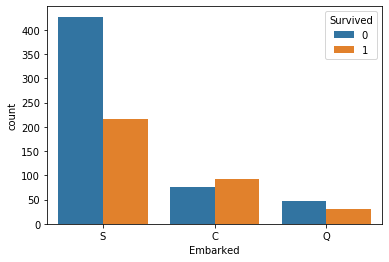

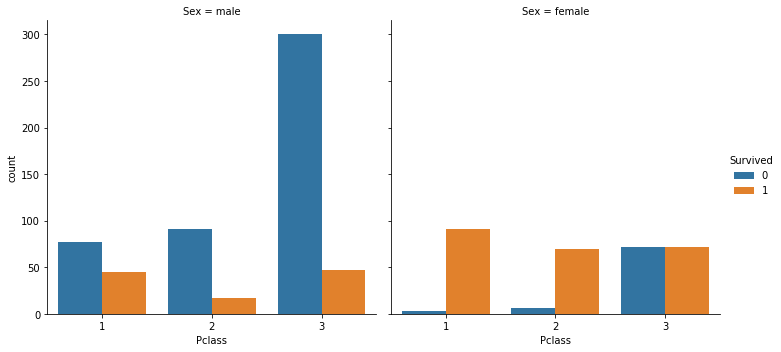

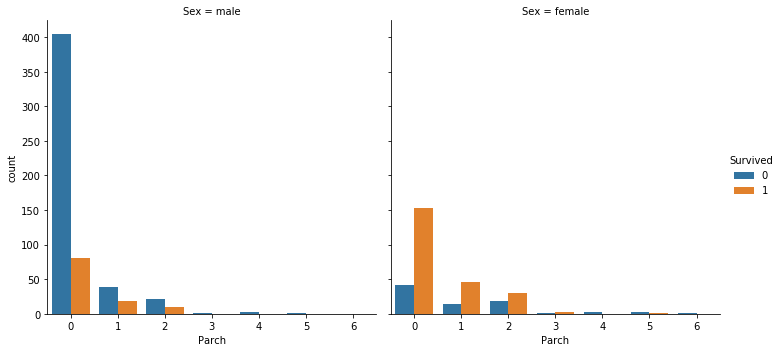

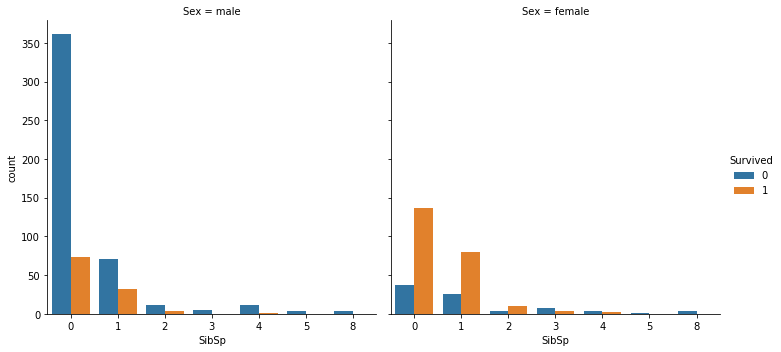

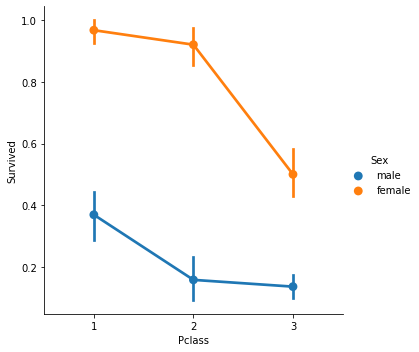

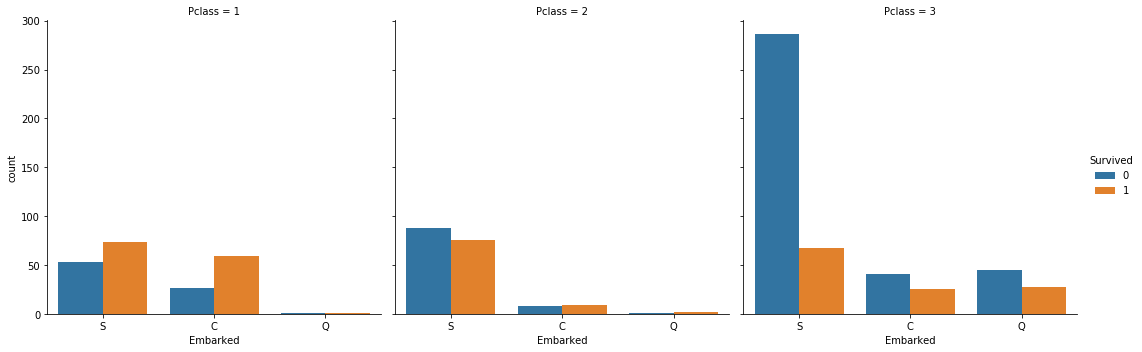

In [9]:
sns.countplot(x = "Sex", hue = "Survived", data = train_dataframe)
plt.show()
sns.countplot(x="Pclass", hue = "Survived", data = train_dataframe)
plt.show()
sns.countplot(x="SibSp", hue = "Survived", data = train_dataframe)
plt.show()
sns.countplot(x="Parch", hue = "Survived", data = train_dataframe)
plt.show()
sns.countplot(x="Embarked", hue = "Survived", data = train_dataframe)
plt.show()
sns.catplot(x = "Pclass", hue = "Survived", col = "Sex", kind = "count", data = train_dataframe)
plt.show()
sns.catplot(x = "Parch", hue = "Survived", col = "Sex", kind = "count", data = train_dataframe)
plt.show()
sns.catplot(x = "SibSp", hue = "Survived", col = "Sex", kind = "count", data = train_dataframe)
plt.show()
sns.catplot(x = 'Pclass',y = 'Survived', hue='Sex', data=train_dataframe, kind = "point") # equivalent to sns.pointplot
plt.show()
sns.catplot(x = 'Embarked',hue = 'Survived', col='Pclass', data=train_dataframe, kind = "count")
plt.show()

From this first look, it seems that the survival rate depends mostly on the sex and on the class.
Moreover, there is an increased death rate for people embarked in "S" (probably correlated with the fact that they are mostly belonging to the 3rd class), and for people with no siblings/spouse and 0 parents/children.

### Analysis of the individuals' titles
Here, I identifiy the mostly used titles and, with the help of Wiki and Google, replace the least common ones to have more homogeneous data. This will help me also to infer the age, wehre is missing.

In [10]:
train_dataframe["Title"] = 0
train_dataframe["Title"] = train_dataframe.Name.str.extract("([a-zA-Z]+)\.")
Xsubm_dataframe["Title"] = 0
Xsubm_dataframe.Title = Xsubm_dataframe.Name.str.extract("([a-zA-Z]+)\.")

def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', "Sir"]:
        return 'Mr'
    elif title in ['Countess', 'Mme',"Dona"]:
        return 'Mrs'
    elif title in ['Mlle', 'Ms', "Lady"]:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

train_dataframe['Title']=train_dataframe.apply(replace_titles, axis=1)
Xsubm_dataframe['Title']=Xsubm_dataframe.apply(replace_titles, axis=1)

# here I use the compact title to infer the age. To have more "randomness", I estimate the
# unknown age with a normal distribution having mean and std drawn from the same "Title" category
for thistitle in list(set(train_dataframe.Title)):    
    row = (train_dataframe.Age.isnull())&(train_dataframe.Title == thistitle)    
    df = train_dataframe[train_dataframe.Title == thistitle]["Age"]    
    mu = df.mean()
    st = df.std() if len(df)>1 else 0        
    value = int(mu + st*np.random.randn(1))    
    train_dataframe.loc[row, "Age"] = value    

for thistitle in list(set(Xsubm_dataframe.Title)):
    row = (Xsubm_dataframe.Age.isnull())&(Xsubm_dataframe.Title == thistitle)
    mu = Xsubm_dataframe[Xsubm_dataframe.Title == thistitle]["Age"].mean()
    st = Xsubm_dataframe[Xsubm_dataframe.Title == thistitle]["Age"].std() if len(Xsubm_dataframe[Xsubm_dataframe.Title == thistitle]["Age"])>1 else 0    
    value = int(mu + st*np.random.randn(1))    
    Xsubm_dataframe.loc[row, "Age"] = value

title_reduced = list(set(train_dataframe.Title))
le_title = LabelEncoder()
le_title.fit(title_reduced)
train_dataframe["Title_LE"] = le_title.transform(train_dataframe.Title)
Xsubm_dataframe["Title_LE"] = le_title.transform(Xsubm_dataframe.Title)

### Create some other new features.

Here, I create two new features, the "age range" and the "fare bin" features. 
I will assign each individuals to a binned age and fare, to have more data homogeneity. 
The idea is that small differences in age or ticket price shouldnt affect directly the survival rate.

In [11]:
age_max = max([train_dataframe.Age.max(), Xsubm_dataframe.Age.max()])
bins = np.linspace(0, age_max, 20)
train_dataframe.loc[:,"Age_bin"] = np.digitize(train_dataframe.Age, bins)
Xsubm_dataframe.loc[:,"Age_bin"] = np.digitize(Xsubm_dataframe.Age, bins)


# ### Add Fare category

# In[7]:


fare_max = max([train_dataframe.Fare.max(), Xsubm_dataframe.Fare.max()])
fare_bins = np.linspace(0, fare_max,10)
train_dataframe.loc[:,"Fare_bin"] = np.digitize(train_dataframe.Fare, fare_bins)
Xsubm_dataframe.loc[:, "Fare_bin"] = np.digitize(Xsubm_dataframe.Fare, fare_bins)

### Analysis of the families onboard

This is the most tedious part. Using internet and cross-references in the database, I tried to check when the info in the database are partial, missing or wrong. 

This section is still not complete.

I don't know how to deal with the possibility that part of the family is in the train dataset and part is in the CV or test dataset.

In [12]:
train_dataframe["Surname"]= 0
train_dataframe["Surname"]= train_dataframe.Name.str.extract("^(.+?),")

## Correcting the SibSp when possible

# Allison: looks like there is 1 Mrs. with 2 children
train_dataframe.loc[297,"SibSp"] = 1
train_dataframe.loc[297,"Parch"] = 1
train_dataframe.loc[305,"SibSp"] = 1
train_dataframe.loc[305,"Parch"] = 1
train_dataframe.loc[498,"SibSp"] = 0
train_dataframe.loc[498,"Parch"] = 2

# Andersson: one misidentified family members (they are not)
train_dataframe.loc[68, ["SibSp", "Parch"]] = [0,0]

# Backstrom
train_dataframe.loc[85,"SibSp"] = 1

### Introducing one hot encoding for *Sex* and *Embarked*.

In [13]:
# One-hot encoding for Sex
a = train_dataframe.loc[:,"Sex"] == "male"
train_dataframe.loc[:,"Male"] = a.astype(int)
train_dataframe.loc[:,"Female"] = (~a).astype(int)
a = Xsubm_dataframe.loc[:,"Sex"] == "male"
Xsubm_dataframe.loc[:,"Male"] = a.astype(int)
Xsubm_dataframe.loc[:,"Female"] = (~a).astype(int)

# One-hot encoding for Embark
embark = []
counter = 0
for i in train_dataframe.loc[:,"Embarked"]:
    if i not in embark:
        embark.append(i)

for p_embarked in embark:
    train_dataframe.loc[:,"Embarked_"+str(p_embarked)] = (train_dataframe.loc[:,"Embarked"] == p_embarked).astype(int)
    Xsubm_dataframe.loc[:,"Embarked_"+str(p_embarked)] = (Xsubm_dataframe.loc[:,"Embarked"] == p_embarked).astype(int)

train_dataframe.head(1)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Title_LE,Age_bin,Fare_bin,Surname,Male,Female,Embarked_S,Embarked_C,Embarked_Q,Embarked_nan
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,...,2,6,1,Braund,1,0,1,0,0,0


## Logistic regression

Here is where the fun starts...

As a first model, I tried to train a logistic regression model on the following features

* Pclass
* Sibsp
* Parch
* Title_LE
* Age_bin
* Fare_bin
* Female
* Male
* Embarked_S, _C, _Q, _nan

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split

In [15]:
features = ["Pclass", "SibSp", "Parch", "Title_LE", "Age_bin", "Fare_bin", 
                "Male","Female", "Embarked_S", "Embarked_C","Embarked_Q","Embarked_nan"]

X = train_dataframe[features].values
Y  = train_dataframe.loc[:, "Survived"].values
Xsubm = Xsubm_dataframe[features].values

Xtrain, Xtest,Ytrain, Ytest = train_test_split(X, Y, test_size = 0.33)

In [16]:
C = np.logspace(-4,1,10)
tuned_parameters = [{"solver":["liblinear"],
                    "C": C,
                    "penalty":["l2","l1"]},
                   {"solver":["newton-cg"],
                    "C": C,
                    "penalty":["l2"]}]

scores = ["precision"]
for score in scores:
    print("Tuning hyperparameters for %s" % score)
    clf = GridSearchCV(LogisticRegression(), tuned_parameters, cv = 3,
                      scoring = "%s_macro" % score)
    clf.fit(Xtrain, Ytrain)   
    print("Best parameters found: {0}. Score {1}\n".format(clf.best_params_, clf.best_score_))        
    print("Grid scores on development set: \n")
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
print(clf.best_estimator_)

Tuning hyperparameters for precision
Best parameters found: {'C': 0.016681005372000592, 'penalty': 'l2', 'solver': 'liblinear'}. Score 0.798267395402722

Grid scores on development set: 

0.315 (+/-0.001) for {'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}
0.315 (+/-0.001) for {'C': 0.0001, 'penalty': 'l1', 'solver': 'liblinear'}
0.315 (+/-0.001) for {'C': 0.00035938136638046257, 'penalty': 'l2', 'solver': 'liblinear'}
0.315 (+/-0.001) for {'C': 0.00035938136638046257, 'penalty': 'l1', 'solver': 'liblinear'}
0.315 (+/-0.001) for {'C': 0.001291549665014884, 'penalty': 'l2', 'solver': 'liblinear'}
0.315 (+/-0.001) for {'C': 0.001291549665014884, 'penalty': 'l1', 'solver': 'liblinear'}
0.786 (+/-0.053) for {'C': 0.004641588833612782, 'penalty': 'l2', 'solver': 'liblinear'}
0.315 (+/-0.001) for {'C': 0.004641588833612782, 'penalty': 'l1', 'solver': 'liblinear'}
0.798 (+/-0.008) for {'C': 0.016681005372000592, 'penalty': 'l2', 'solver': 'liblinear'}
0.315 (+/-0.001) for {'C': 0.016681

c:\program files\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\program files\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\program files\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\program files\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\program files\python37\lib\site-packages\skle

In [17]:
print("Scores on the train dataset")
print(classification_report(Ytrain, clf.best_estimator_.predict(Xtrain)))

print("Scores on the test dataset")
print(classification_report(Ytest, clf.best_estimator_.predict(Xtest)))
Ypred = clf.best_estimator_.predict(Xtest)
accuracy_dict = {}
accuracy_dict["logReg"] = [accuracy_score(Ytest, Ypred), clf.best_estimator_, ]
print("Accuracy: {0:.4g}%".format(accuracy_score(Ytest, Ypred)*100))

Scores on the train dataset
              precision    recall  f1-score   support

           0       0.78      0.95      0.86       376
           1       0.86      0.55      0.67       220

    accuracy                           0.80       596
   macro avg       0.82      0.75      0.77       596
weighted avg       0.81      0.80      0.79       596

Scores on the test dataset
              precision    recall  f1-score   support

           0       0.75      0.95      0.84       173
           1       0.88      0.55      0.68       122

    accuracy                           0.78       295
   macro avg       0.82      0.75      0.76       295
weighted avg       0.80      0.78      0.77       295

Accuracy: 78.31%


# Experimenting with random stuff.
## SVM

In [18]:
from sklearn.svm import SVC

parameters = [{"C":[0.01,0.03,0.1,0.3,1.,3.,10],
              "kernel": ["linear", "rbf", "sigmoid"],
              "gamma": [0.01,0.03,0.1,0.3,1.,3.,10]}]


clf = GridSearchCV(estimator=SVC(),
                   param_grid=parameters, scoring = "accuracy", cv = 5)
clf.fit(Xtrain, Ytrain)
print("Best parameters found: {0}. Score {1}\n".format(clf.best_params_, clf.best_score_))        

Ypred = clf.predict(Xtest)
accuracy_dict["svm"] = [accuracy_score(Ytest, Ypred), clf.best_estimator_]
print("Accuracy on the test set: {0}%".format(accuracy_score(Ytest, Ypred)*100))

Best parameters found: {'C': 3.0, 'gamma': 0.03, 'kernel': 'rbf'}. Score 0.837248322147651

Accuracy on the test set: 82.71186440677965%


In [19]:
print("Model\tAccuracy")
bestAccuracy = 0
for key in accuracy_dict.keys():    
    print("{0}\t{1}%".format(key, accuracy_dict[key][0]))
    if accuracy_dict[key][0]> bestAccuracy:
        bestModel = key

Model	Accuracy
logReg	0.7830508474576271%
svm	0.8271186440677966%


In [20]:
print("Best model is " + bestModel)

pid = Xsubm_dataframe.loc[:,"PassengerId"].values
res = np.zeros((len(pid),2), dtype = int)
res[:,0] = pid
res[:,1] = accuracy_dict[bestModel][1].predict(Xsubm)
np.savetxt("submission.csv", res, header = "PassengerId,Survived", delimiter = ",", fmt = "%d", comments = '')

Best model is svm
